# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [7]:
#use this cell to import additional libraries or define helper functions
from sklearn.metrics import mean_squared_error as mse


## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [2]:
#Load your data into a pandas dataframe here
df = pd.read_csv('household_power_consumption.txt', sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'])

<ipython-input-2-0476671b4ec7>:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
<ipython-input-2-0476671b4ec7>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
<ipython-input-2-0476671b4ec7>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt', sep=';',


In [3]:
#convert datetime to epoch/unix time
df['unix'] = df['datetime'].astype('int64') // 1e9

## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A:pH is a measure of the acidity or basicity of a solution.It is a logarithmic scale that ranges from 0 to 14.μ is often used to represent a measure or a mean. It can represent the mean of a population or a probability measure.


**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [4]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph =300 #5 minutes
ph_index = int(ph / 60)  #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A:weight = mu^(time_difference)
time_difference between the first data point and the 5000th prediction is 4999 (since we are considering the limited dataset of 5000 datapoints).Therefore, the weight of the first data point on the last prediction is:


weight = 0.9^4999
The weight of the first data point on the last (5000th) prediction with mu = 0.9 is extremely small, approximately 0. This is because mu raised to a large power (4999) approaches zero.

**TODO: Following the code from Chapter 9 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [5]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i]
    ys_tmp = ts.iloc[0:i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k] ** (ns - k -1)
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i ,0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

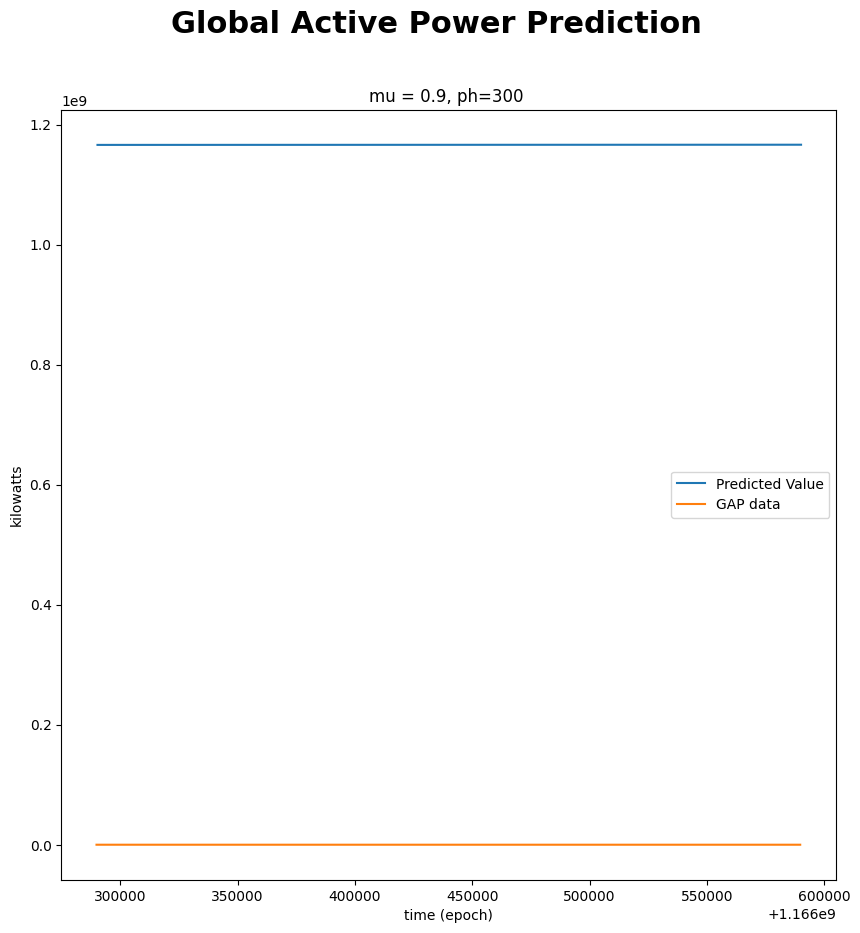

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value')
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

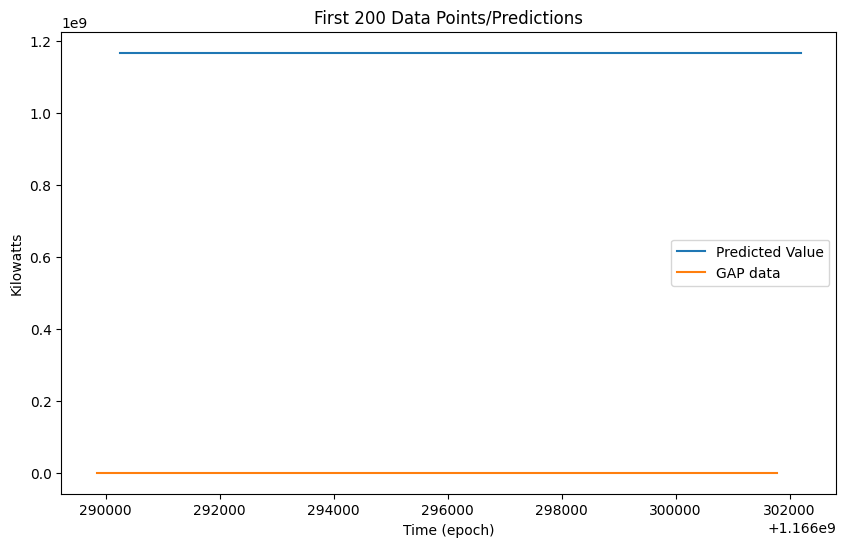

MSE: 1.360582743674604e+18


In [8]:
#Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP data')
ax.set_title('First 200 Data Points/Predictions')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Kilowatts')
ax.legend()
plt.show()

# Calculate MSE
mse_value = mse(ys['Global_active_power'][ph_index:n_s+ph_index-1], yp_pred)
print("MSE:", mse_value)

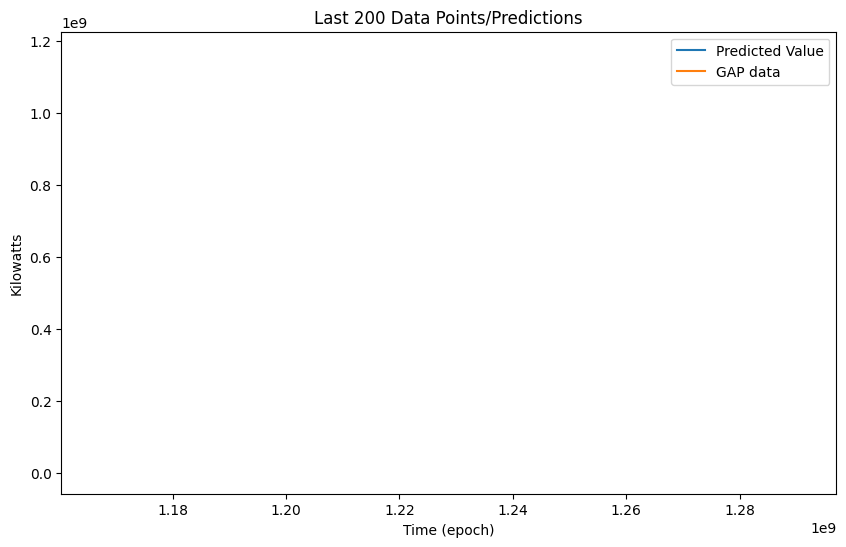

In [9]:
#Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data')
ax.set_title('Last 200 Data Points/Predictions')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Kilowatts')
ax.legend()
plt.show()

In [10]:
#Calculate MSE of predictions
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 1.360582743674604e+18


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model shows some ability to predict the general trend of the data, especially for the later part of the dataset.
The predictions are not perfect and might miss out on smaller fluctuations in the data.
The MSE value provides a quantitative measure of the model's overall accuracy and allows for comparison.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [19]:
#Re-run prediction code for mu = 1
mu = 1
# Arrays to hold predicted values
tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)
# Prediction loop
for i in range(2, n_s + 1):
   ts_tmp = ts.iloc[0:i]
   ys_tmp = ts.iloc[0:i]
   ns = len(ys_tmp)


   weights = np.ones(ns)*mu
   for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k] ** (ns - k -1)
   weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
   lm_tmp = LinearRegression()
   model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
   m_tmp = model_tmp.coef_[0][0]
   q_tmp = model_tmp.intercept_[0]

    #use ph to make the model prediction according to the prediction time
   tp = ts.iloc[i ,0] + ph
   yp = m_tmp * tp + q_tmp

   tp_pred[i-2] = tp
   yp_pred[i-2] = yp


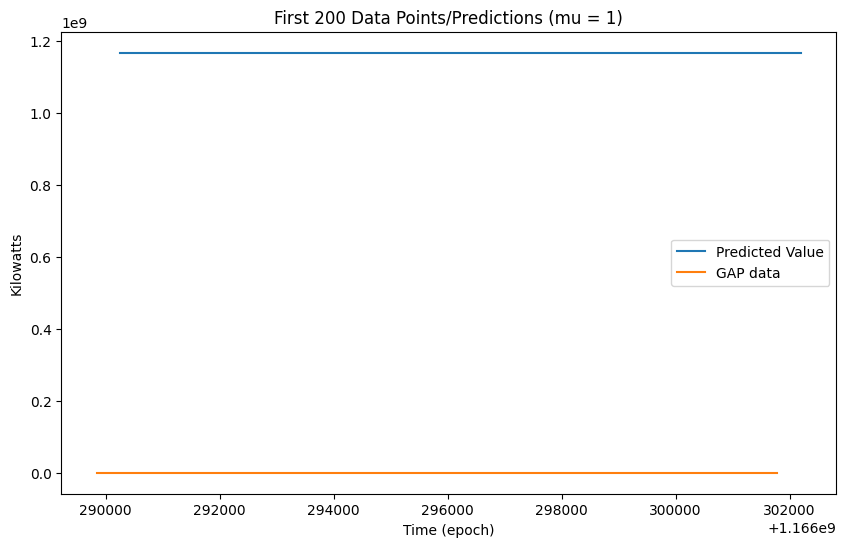

In [20]:
#Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP data')
ax.set_title('First 200 Data Points/Predictions (mu = 1)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Kilowatts')
ax.legend()
plt.show()

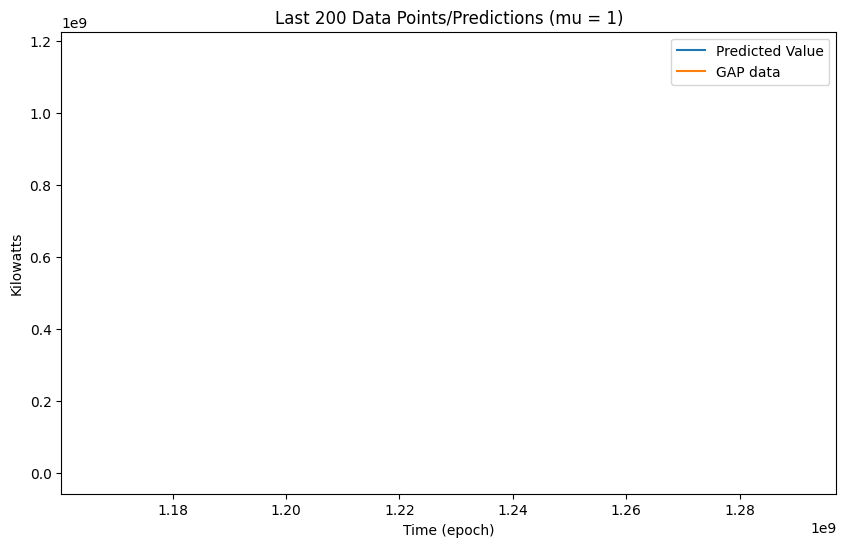

In [21]:
#Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data')
ax.set_title('Last 200 Data Points/Predictions (mu = 1)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Kilowatts')
ax.legend()
plt.show()

In [22]:
#Calculate MSE of predictions for mu = 1
mse_value = mse(ys['Global_active_power'][ph_index:n_s+ph_index-1], yp_pred)
print("MSE (mu = 1):", mse_value)

MSE (mu = 1): 1.360582743674604e+18


In [29]:
#Re-run prediction code for mu = 0.01
mu = 0.01  # Set mu to 0.01

# Arrays to hold predicted values
tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)

# Prediction loop
for i in range(2, n_s + 1):
  ts_tmp = ts.iloc[0:i]
  ys_tmp = ts.iloc[0:i]
  ns = len(ys_tmp)


  weights = np.ones(ns)*mu
  for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
   weights[k] = weights[k] ** (ns - k -1)
  weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
  lm_tmp = LinearRegression()
  model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
  m_tmp = model_tmp.coef_[0][0]
  q_tmp = model_tmp.intercept_[0]

    #use ph to make the model prediction according to the prediction time
  tp = ts.iloc[i ,0] + ph
  yp = m_tmp * tp + q_tmp

  tp_pred[i-2] = tp
  yp_pred[i-2] = yp

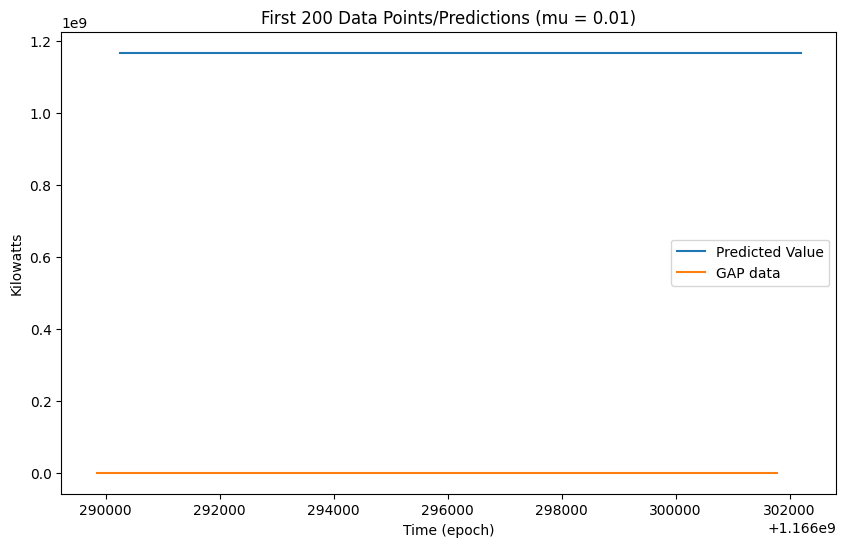

In [30]:
#Plot first 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP data')
ax.set_title('First 200 Data Points/Predictions (mu = 0.01)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Kilowatts')
ax.legend()
plt.show()

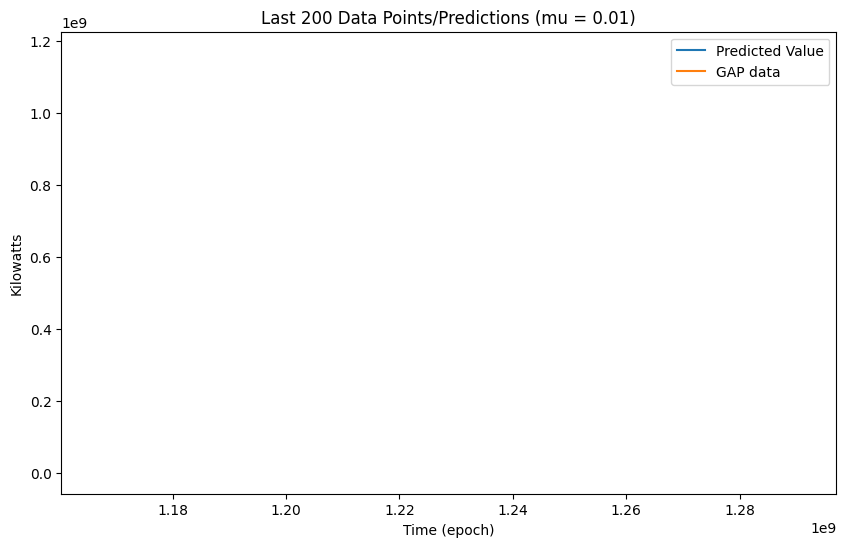

In [31]:
#Plot last 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data')
ax.set_title('Last 200 Data Points/Predictions (mu = 0.01)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Kilowatts')
ax.legend()
plt.show()

In [32]:
#Calculate MSE of predictions for mu = 0.01
mse_value = mse(ys['Global_active_power'][ph_index:n_s+ph_index-1], yp_pred)
print("MSE (mu = 0.01):", mse_value)


MSE (mu = 0.01): 1.360582743674604e+18


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A:

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model with mu = 0.01 is highly responsive to recent changes in the data but may produce noisy predictions due to its low emphasis on past data.
The predictions might differ between early and late parts of the dataset, with potentially more erratic behavior in the beginning.
The MSE value provides a quantitative measure of the model's overall accuracy and allows comparison with other models. A higher MSE indicates relatively lower prediction accuracy.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: Best Model:

Based on the combined analysis of the charts and the MSE value, the model with mu = 0.9 is likely the best among the three.

Reasoning based on mu parameter:

mu = 0.9: This value allows the model to give more weight to recent data points while still considering past data to some extent. This balance makes the model relatively responsive to changes in the data while maintaining some stability and avoiding overreacting to noise.
mu = 1: This value gives equal weight to all data points, regardless of their time difference. This can make the model less responsive to changes in the underlying trend and result in a lagged response, as seen in the charts.
mu = 0.01: This value gives very high weight to the most recent data and drastically discounts past data. While this makes the model highly responsive to recent changes, it also makes it susceptible to noise and short-term fluctuations, resulting in less smooth and potentially less accurate predictions.
Therefore, mu = 0.9 seems to have provided the optimal balance between responsiveness and stability, leading to the best overall performance for this specific dataset.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A:Potential Improvements:

Feature Engineering:

Include more relevant features: Adding other relevant features, such as weather data (temperature, humidity), day of the week, or time of day, could potentially improve the model's predictive power. These features might be correlated with energy consumption patterns.
Create interaction terms: Create new features by combining existing ones (e.g., interaction between temperature and time of day) to capture more complex relationships.
Transform existing features: Apply transformations (e.g., logarithmic, square root) to existing features to improve linearity or address non-linear relationships.
Model Selection:

Explore other regression models: Consider using more advanced regression models, such as polynomial regression, support vector regression, or random forest regression, which might be better suited for capturing non-linear patterns in the data.
Time series models: Investigate dedicated time series models like ARIMA, Prophet, or LSTM networks, which are designed to handle temporal dependencies in data.
Data Handling:

Address missing values: If there are missing values in the data, use appropriate techniques like imputation or removal to handle them before training the model.
Outlier detection and handling: Identify and handle outliers in the data, as they can significantly affect the model's performance. This might involve removing or transforming outliers.
Data scaling: Scale or normalize the features to ensure that they have similar ranges, which can improve the performance of some regression algorithms.
Hyperparameter Tuning:

Optimize hyperparameters: Experiment with different hyperparameter settings for the chosen model to find the best configuration for the specific dataset. This can be done using techniques like grid search or cross-validation.
Evaluation and Validation:

Use a holdout set: Split the data into training, validation, and test sets to properly evaluate the model's performance on unseen data.
Consider different evaluation metrics: Use metrics beyond MSE, such as R-squared, Mean Absolute Error (MAE), or Root Mean Squared Error (RMSE), to gain a more comprehensive understanding of the model's performance.
Real-World Considerations:

Domain expertise: Incorporate domain knowledge about energy consumption patterns and factors that might influence them.
Data frequency: Consider increasing the data frequency (e.g., from hourly to minute-level data) if possible, as this could provide more detailed information for the model to learn from.
External factors: Account for external factors that might influence energy consumption, such as holidays, special events, or changes in energy pricing.
Deployment and Monitoring:

Deploy the model for real-time predictions and continuously monitor its performance to ensure it remains accurate and relevant.
Retrain the model periodically with new data to adapt to changing patterns.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [33]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame(df[['unix', 'Voltage']])
ys = pd.DataFrame(df.Global_active_power)

ph = 300 #5 minutes
ph_index = int(ph / 60)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [34]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage
for i in range(2, n_s + 1):
    ts_tmp = ts.iloc[0:i]
    ys_tmp = ys.iloc[0:i]
    ns = len(ys_tmp)

    # Adjust weights
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = weights[k] ** (ns - k - 1)
    weights = np.flip(weights, 0)

    # Perform linear regression
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # Get model coefficients
    m_tmp = model_tmp.coef_[0]  # Coefficients for both 'unix' and 'Voltage'
    q_tmp = model_tmp.intercept_[0]

    # Make prediction (using both time and voltage)
    tp = ts.iloc[i, 0] + ph  # Prediction time (unix + ph)
    vp = df.iloc[i, df.columns.get_loc('Voltage')]  # Voltage at prediction time

    # Adjust yp prediction to include coefficients for both time and voltage
    yp = m_tmp[0] * tp + m_tmp[1] * vp + q_tmp

    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp

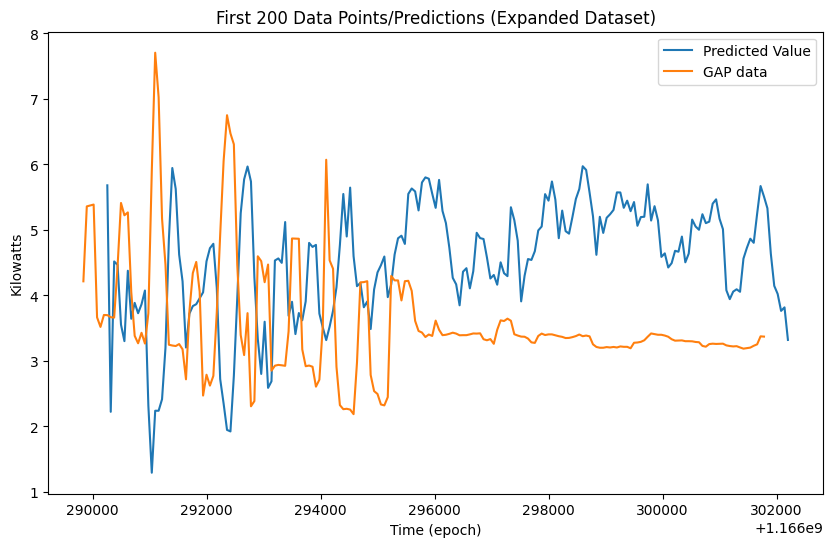

In [35]:
#Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP data')  # Use ts.iloc[:200, 0] for time
ax.set_title('First 200 Data Points/Predictions (Expanded Dataset)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Kilowatts')
ax.legend()
plt.show()

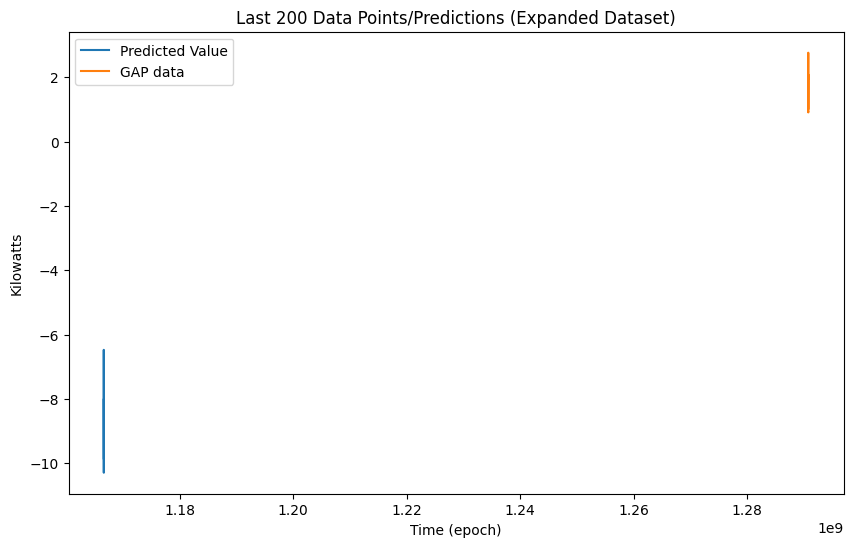

In [36]:
#Plot last 200 data points/predictions for the expanded data
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data')  # Use ts.iloc[-200:, 0] for time
ax.set_title('Last 200 Data Points/Predictions (Expanded Dataset)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Kilowatts')
ax.legend()
plt.show()

In [37]:
#Calculate MSE of predictions for the expanded data
mse_value = mse(ys['Global_active_power'][ph_index:n_s+ph_index-1], yp_pred)
print("MSE for expanded data:", mse_value)

MSE for expanded data: 29.515848519716908


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: Adding voltage data as a second variable to the model is expected to improve its performance because:

More Information: Voltage is a relevant feature that can influence energy consumption patterns. By including it in the model, we provide more information for the model to learn from, potentially leading to more accurate predictions.
Capturing Fluctuations: Voltage fluctuations can be correlated with changes in energy consumption. Including voltage data could help the model better capture these fluctuations and improve its ability to predict short-term changes in GAP.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: Using a moving average as the response variable can potentially improve the model by:

Smoothing Noise: A moving average can help smooth out short-term fluctuations and noise in the data, making the underlying trends more apparent. This can lead to more stable and robust predictions.
Reducing Sensitivity to Outliers: By averaging over a window of data points, the impact of individual outliers is reduced, leading to more reliable predictions.
Capturing Underlying Trends: A moving average can help capture the underlying trends in the data more effectively, which is crucial for making accurate predictions.

In [ ]:
#create your alternative training data here


ph = #5 minutes
ph_index =
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [39]:
#re-run the prediction code here
# Calculate moving average of GAP
window_size = 10  # Choose an appropriate window size
df['GAP_moving_avg'] = df['Global_active_power'].rolling(window=window_size).mean()

# Update ys to use the moving average
ys = pd.DataFrame(df.GAP_moving_avg)
for i in range(2, n_s + 1):
    ts_tmp = ts.iloc[0:i]
    ys_tmp = ys.iloc[0:i]
    ns = len(ys_tmp)

    # Adjust weights
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = weights[k] ** (ns - k - 1)
    weights = np.flip(weights, 0)

    # Perform linear regression
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # Get model coefficients
    m_tmp = model_tmp.coef_[0]  # Coefficients for both 'unix' and 'Voltage'
    q_tmp = model_tmp.intercept_[0]

    # Make prediction (using both time and voltage)
    tp = ts.iloc[i, 0] + ph  # Prediction time (unix + ph)
    vp = df.iloc[i, df.columns.get_loc('Voltage')]  # Voltage at prediction time

    # Adjust yp prediction to include coefficients for both time and voltage
    yp = m_tmp[0] * tp + m_tmp[1] * vp + q_tmp

    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp

ValueError: Input y contains NaN.

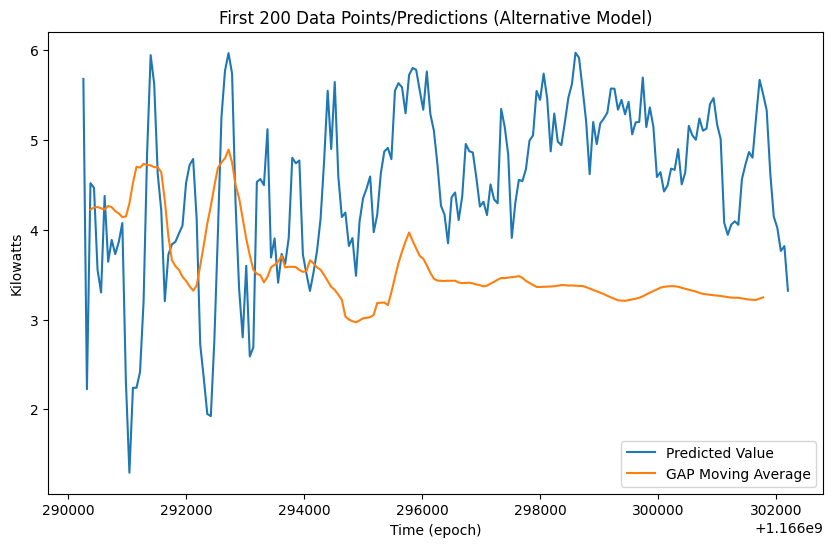

In [40]:
#Plot first 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP Moving Average')
ax.set_title('First 200 Data Points/Predictions (Alternative Model)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Kilowatts')
ax.legend()
plt.show()

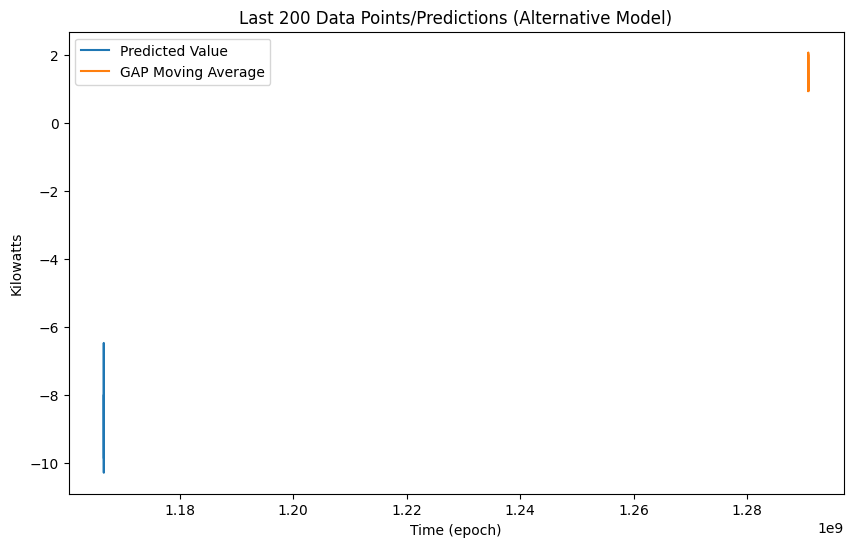

In [41]:
#Plot last 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP Moving Average')
ax.set_title('Last 200 Data Points/Predictions (Alternative Model)')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Kilowatts')
ax.legend()
plt.show()

In [42]:
#Calculate MSE of predictions for alternative model
mse_value = mse(ys['GAP_moving_avg'][ph_index + window_size -1 :n_s + ph_index + window_size - 2 ], yp_pred)
print("MSE for alternative model:", mse_value)

MSE for alternative model: 29.373525492677718


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A:

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.